# Develop ESN-JAX

In [444]:
import jax
import jax.numpy as jnp
import flax.linen as nn
from flax.linen.activation import tanh

from typing import Tuple, Any, Callable, Sequence, Optional


import matplotlib.pyplot as P 
import numpy as np

In [445]:
def createSparseMatrix(nRes, sparsity, seed):
    '''
    Utility function: creates Sparse Matrix
    Returns:
            W (np.array): sparse matrix of size (**nReservoir**, **nReservoir**).
    '''
    rows, cols = nRes, nRes
#     W = jax.random.uniform(jax.random.PRNGKey(0), shape = (rows, cols), minval=-1.0, maxval=1.0)
    np.random.seed(seed)
    W = np.random.uniform(-1, 1, (rows, cols)) # randomly chosen matrix, entries in range [-1,1]

    num_zeros = np.ceil(sparsity * rows).astype(np.int64) # number of zeros to set
    for iCol in range(cols):
        row_indices  = np.random.permutation(rows) # choose random row indicies
        zero_indices = row_indices[:num_zeros]     # get the num_zeros of them
        W[zero_indices, iCol] = 0                  # set (zero_indicies, iCol) to 0
    return jnp.asarray(W)


class ESN(nn.Module):
    nInput   : int
    nOutput  : int
    nRes     : int
    alpha    : float = 0.4
    rho      : float = 0.99
    sparsity : float = 0.90
    seed     : int   = 2
    
    def setup(self):
        self.W_in  = jax.random.normal(jax.random.PRNGKey(0), shape = (self.nRes, self.nInput))
        W          = createSparseMatrix(self.nRes, self.sparsity, self.seed)
        self.W_res = self.rho * W / (np.max(np.absolute(np.linalg.eigvals(W))))
        self.W_out = jax.random.normal(jax.random.PRNGKey(0), shape = (self.nRes, self.nOutput))
    
    def __call__(self, h, x):
        h_new = (1 - self.alpha) * h + self.alpha * tanh(self.W_res.dot(h) + self.W_in.dot(x))
        y = self.W_out.T.dot(h_new)
        return h_new, y

In [486]:
nInput = 5
nRes   = 100
alpha  = 0.4
nOutput = 4

hidden = jnp.zeros((nRes,1))
x     = jnp.ones((nInput, 1))
esn   = ESN(nInput = nInput, nOutput=nOutput, nRes = nRes, alpha = alpha)
var   = esn.init(jax.random.PRNGKey(0), hidden, x)
model = esn.bind(var)

In [500]:
H = []
Y = []
for key in range(50):
    x = jax.random.normal(jax.random.PRNGKey(key), shape = (nInput,1))
    hidden, y = model(hidden,x)
    H.append(hidden)
    Y.append(y)

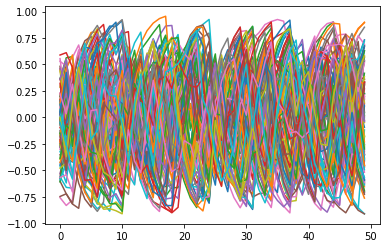

In [501]:
P.plot(np.asarray(H)[:,:,0]);

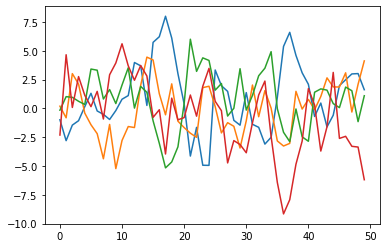

In [502]:
P.plot(np.asarray(Y)[:,:,0]);